In [1]:
#Import libraries
import re
import requests
from bs4 import BeautifulSoup as soup
import pandas as pd
import requests
from bs4 import BeautifulSoup
from bs4 import Comment

In [2]:
url ='https://www.basketball-reference.com/leagues/NBA_2012_standings.html'

In [3]:
def nba_standing(url):
    #function to parse each row
    def parse_row(row):
        return [x.text for x in row.findAll('td')]
    
    #Getting url and using Beautiful Soup to Parse it
    r = requests.get(url)
    soup = BeautifulSoup(r.content)
    all_comments = soup.find_all(string=lambda text: isinstance(text, Comment))
    for item in all_comments:
        if "expanded_standings" in item:
            adv = BeautifulSoup(item)

            row_objects = adv.find("table", id="expanded_standings")
            header_objects = adv.find("table", id="expanded_standings")

            if not row_objects:
                #print('skip')
                continue # skip comment without table - go back to `for`

            row_objects = row_objects.find("tbody").findAll("tr")
            header_objects = header_objects.findAll("th")
   #Expanded Standings
    list_parsed_rows =[parse_row(row) for row in row_objects[0:]] # list_parsed_rows
    df = pd.DataFrame(list_parsed_rows)
    df = df.iloc[:, [0, 1, 2, 3, 4, 5]]  #Select certain columns using index
    header = [item.text for item in header_objects]
    df.columns = header[8:14]  #Chose only headers I neeed for df
    df.insert(0, 'Rank',list(range(1, 31)) )
    #Fxn to split numbers
    def splitfxn(name):
        list_wins = []
        list_losses = []
        for i, score in enumerate(range(0,len(df[name]))):
            x =df[name][i].split('-')
            list_wins.append(int(x[0]))
            list_losses.append(int(x[1].strip())) 
        df['Wins ' + str(name)] = list_wins
        df['Losses ' + str(name)] = list_losses
    #Add column with Year
    num = re.findall('\d+', url )
    year = num[0]
    #Add fixed values
    splitfxn('Overall')
    splitfxn('Home')
    splitfxn('Road')
    df['Perc_WinHome'] = (df['Wins Home'] / (df['Wins Home'] + df['Losses Home'])) *100
    df['Perc_LossHome'] = (df['Losses Home'] / (df['Wins Home'] + df['Losses Home'])) *100
    df['Perc_WinRoad'] = (df['Wins Road'] / (df['Wins Road'] + df['Losses Road'])) *100
    df['Perc_LossRoad'] = (df['Losses Road'] / (df['Wins Road'] + df['Losses Road'])) *100
    df['Year'] = year
    df = df.drop(df.loc[:, 'Overall':'W'].columns, axis = 1)
    #Used to fix teams that had changed names and or cities
    df = df.replace(to_replace='New Jersey Nets', value='Brooklyn Nets')
    df = df.replace(to_replace ="Charlotte Bobcats", value ="Charlotte Hornets")
    df = df.replace(to_replace ="New Orleans Hornets", value="New Orleans Pelicans")
    return df
    
    

In [4]:
test = nba_standing(url)  #Test if it worked
test

,Rank,Team,Wins Overall,Losses Overall,Wins Home,Losses Home,Wins Road,Losses Road,Perc_WinHome,Perc_LossHome,Perc_WinRoad,Perc_LossRoad,Year
0,1,Chicago Bulls,50,16,26,7,24,9,78.787879,21.212121,72.727273,27.272727,2012
1,2,San Antonio Spurs,50,16,28,5,22,11,84.848485,15.151515,66.666667,33.333333,2012
2,3,Oklahoma City Thunder,47,19,26,7,21,12,78.787879,21.212121,63.636364,36.363636,2012
3,4,Miami Heat,46,20,28,5,18,15,84.848485,15.151515,54.545455,45.454545,2012
4,5,Indiana Pacers,42,24,23,10,19,14,69.696970,30.303030,57.575758,42.424242,2012
5,6,Los Angeles Lakers,41,25,26,7,15,18,78.787879,21.212121,45.454545,54.545455,2012
6,7,Memphis Grizzlies,41,25,26,7,15,18,78.787879,21.212121,45.454545,54.545455,2012
7,8,Atlanta Hawks,40,26,23,10,17,16,69.696970,30.303030,51.515152,48.484848,2012
8,9,Los Angeles Clippers,40,26,24,9,16,17,72.727273,27.272727,48.484848,51.515152,2012
9,10,Boston Celtics,39,27,24,9,15,18,72.727273,27.272727,45.454545,54.545455,2012


### Looking at Syntax of the ESPN website

https://www.basketball-reference.com/leagues/NBA_2011_standings.html
https://www.basketball-reference.com/leagues/NBA_2019_standings.html  




In [5]:
#Function to scrape data frome a range of years and append all that data to a single dataframe
def nba_standing_years(start_year, end_year):
    for i in range(0,end_year+1-start_year):
        if i == 0:
            a = start_year 
            url=f'https://www.basketball-reference.com/leagues/NBA_{a}_standings.html'  
            df = nba_standing(url)
            print(start_year)
        elif i > 0:
            a = start_year+i 
            url=f'https://www.basketball-reference.com/leagues/NBA_{a}_standings.html'  
            df2 = nba_standing(url)
            df = df.append(df2)
            print(start_year+i)  
    return df
  

In [6]:
df = nba_standing_years(2009,2019)  #Scrape data from a ten year period
df

2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019


,Rank,Team,Wins Overall,Losses Overall,Wins Home,Losses Home,Wins Road,Losses Road,Perc_WinHome,Perc_LossHome,Perc_WinRoad,Perc_LossRoad,Year
0,1,Cleveland Cavaliers,66,16,39,2,27,14,95.121951,4.878049,65.853659,34.146341,2009
1,2,Los Angeles Lakers,65,17,36,5,29,12,87.804878,12.195122,70.731707,29.268293,2009
2,3,Boston Celtics,62,20,35,6,27,14,85.365854,14.634146,65.853659,34.146341,2009
3,4,Orlando Magic,59,23,32,9,27,14,78.048780,21.951220,65.853659,34.146341,2009
4,5,Denver Nuggets,54,28,33,8,21,20,80.487805,19.512195,51.219512,48.780488,2009
5,6,Portland Trail Blazers,54,28,34,7,20,21,82.926829,17.073171,48.780488,51.219512,2009
6,7,San Antonio Spurs,54,28,28,13,26,15,68.292683,31.707317,63.414634,36.585366,2009
7,8,Houston Rockets,53,29,33,8,20,21,80.487805,19.512195,48.780488,51.219512,2009
8,9,Dallas Mavericks,50,32,32,9,18,23,78.048780,21.951220,43.902439,56.097561,2009
9,10,New Orleans Pelicans,49,33,28,13,21,20,68.292683,31.707317,51.219512,48.780488,2009


In [7]:
len(df['Team'].unique())  #Testing to see if it got 30 teams total from NBA

30

In [8]:
## Import the packages
from scipy import stats 

# For visualizing distributions
import seaborn as sns
import matplotlib.pyplot as plt

## Paired Sample T-test   

Wins at Home vs Wins on the Road.
Teams play 82 Games.  Half of the games are played at home and half on the road.

Null Hypothesis No difference between home court and road games  
Alternate Hypothesis  There is a difference between home court and road games
 

## Q- Q Plot
Quantile- Quantilele plot is graphical tool to help us assess if a set of data plausibly came from normal or exponential data.
Data should be on the red line if it's not the data may not be normally distributed.

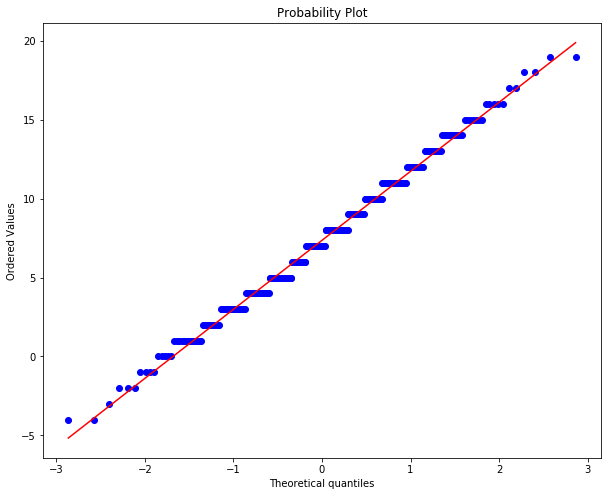

In [14]:
#Q-Q Plot
plt.figure(figsize=(10,8))
df['difference'] = df['Wins Home'] - df['Wins Road']
stats.probplot(df['difference'], plot= plt)
plt.savefig('boxplot_outliers.png')

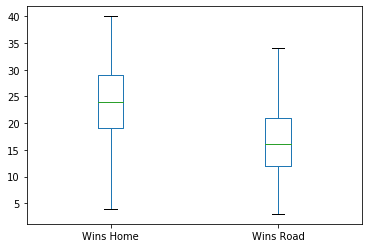

In [15]:
df[['Wins Home','Wins Road']].plot(kind='box')
# This saves the plot as a png file
plt.savefig('boxplot_outliers.png')
#The tails are the outliers low and high,  The lower box is quartile 1 and the higher box is quartile 3.
#Line in the middle is the median of 60% for Home and 30% for Road

$μ_{W}$ = No difference between home court and road games  
$μ_{E}$ = There is a difference between home court and road games  
$H_{o}$: $μ_{W}$ = $μ_{E}$  
$H_{a}$: $μ_{W}$ != $μ_{E}$  

In [11]:
stats.ttest_rel(df['Perc_WinHome'], df['Perc_WinRoad'])

Ttest_relResult(statistic=30.582511875829223, pvalue=3.41147920239787e-98)

### Reject Null Hypothesis

In [12]:
df.to_csv(r'nba_standings.csv')

In [13]:
#![alt text](imagename.png "Title")  Imbedded picture in notebook

![alt text](nba_road_home.png "Title")

##  Shows Home court gives obvious advantage in the NBA.
Imported from tableau